# Example cross-correlation FFS PicoQuant Luminosa

Load packages

In [6]:
from brighteyes_ffs.fcs.atimes_data import load_atimes_data, atimes_data_2_channels, atimes_data_2_duration
from brighteyes_ffs.fcs.atimes2corrparallel import atimes_file_2_corr as correlate_file
from brighteyes_ffs.fcs.atimes2corrparallel import atimes_2_corrs_parallel as correlate_data
from brighteyes_ffs.fcs.arrivaltimes2filteredtimetrace import atimes_filtered
from brighteyes_ffs.fcs.atimes2hist import atimes_data_2_hist
from brighteyes_ffs.fcs.corr_input_from_kw import get_corr_input
from brighteyes_ffs.fcs.detectors import distance_between_elements
from brighteyes_ffs.fcs.filter_g import good_chunks_from_g_obj as good_chunks_idx
from brighteyes_ffs.fcs.fcs_fit import fcs_fit
from brighteyes_ffs.fcs.filter_ap import filter_range, filter_ap
from brighteyes_ffs.fcs.plot_corrs_scheme import plot_correlations_microimage
from brighteyes_ffs.fcs.plot_fingerprint import plot_fingerprint_luminosa

from brighteyes_ffs.tools.stokes_einstein import stokes_einstein
from brighteyes_ffs.tools.fit_curve import fit_curve
from brighteyes_ffs.tools.print_tools import print_table

import matplotlib.pyplot as plt
import numpy as np

Load data and make histograms

In [7]:
file = r'D:\PTU for Vicidomini\DNA_40bp_Alexa488.ptu'
data = load_atimes_data(file) # read the raw data
atimes_data_2_hist(data)      # make the arrival time histograms
duration = atimes_data_2_duration(data, macrotime=1e-12) # measurement duration

tag index out of order @ 'DNA_40bp_Alexa488.ptu' tagid='DetectorTCSPCChan', index=4, typecode=268435464, value=9
tag index out of order @ 'DNA_40bp_Alexa488.ptu' tagid='DetectorNumTCSPCChan', index=4, typecode=268435464, value=23


## Calculate correlations

First, we calculate all cross-correlations between all detector elements, resulting in 23x23 correlations. Then, we average over all correlations between 'equivalent' detector pairs, limiting the final number of correlations to 12 (6 different angles, two distances per angle).

In [3]:
accuracy = 20 # the higher this number, the more points the correlation will have
split = 10 # split the data in segments of this length (in seconds) and calculate the ACF for each segment separately
return_time_trace = True # return the intensity time trace
detector = 'pda-23'
list_of_g, list_of_g_out, averaging = get_corr_input(corrtype='all cross-correlations', det=detector)

Plot of the correlations we will calculate. Each panel represents a single correlation curve. Legend:
* Light grey detector element: not used for this analysis
* Dark grey detector element: used in this analysis but not for this specific correlation curve
* Colored detector element: used for this correlation curve
* Arrow: cross-correlation between the two detector elements is calculated for the curve. All cross-correlations in the same panel are averaged.

E.g., G.Angle0_1 contains the average correlation curve of 14 cross-correlations between detector elements displaced by 1 unit in the horizontal-right direction.

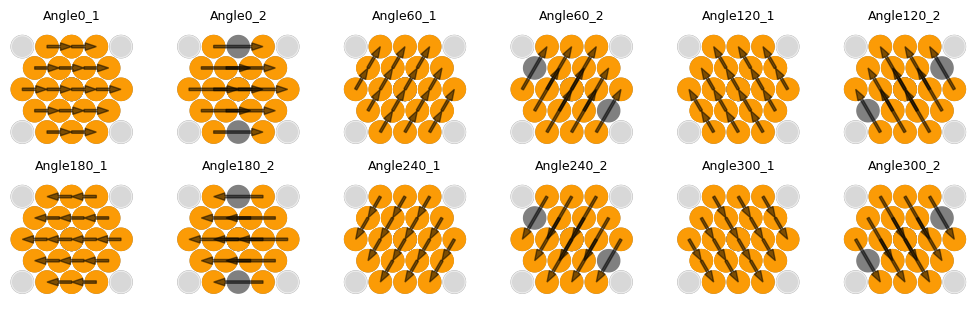

In [4]:
plot_correlations_microimage(detector, list_of_g, list_of_g_out, averaging, figsize=(10,3))

Calculate correlations and store them in the object G. A compressed time-trace for each channel is stored in the 2D array time_trace.

In [5]:
G, time_trace = correlate_file(file, list_of_g=list_of_g, accuracy=accuracy, split=split, time_trace=return_time_trace, list_of_g_out=list_of_g_out, averaging=averaging)

tag index out of order @ 'DNA_40bp_Alexa488.ptu' tagid='DetectorTCSPCChan', index=4, typecode=268435464, value=9
tag index out of order @ 'DNA_40bp_Alexa488.ptu' tagid='DetectorNumTCSPCChan', index=4, typecode=268435464, value=23


Calculating correlation x0909
Extracting photons channels 09 and 09
   Filter 0
Calculating correlation x0910
Extracting photons channels 09 and 10
   Filter 0
Calculating correlation x0911
Extracting photons channels 09 and 11
   Filter 0
Calculating correlation x0912
Extracting photons channels 09 and 12
   Filter 0
Calculating correlation x0913
Extracting photons channels 09 and 13
   Filter 0
Calculating correlation x0914
Extracting photons channels 09 and 14
   Filter 0
Calculating correlation x0915
Extracting photons channels 09 and 15
   Filter 0
Calculating correlation x0916
Extracting photons channels 09 and 16
   Filter 0
Calculating correlation x0917
Extracting photons channels 09 and 17
   Filter 0
Calculating correlation x0918
Extracting photons channels 09 and 18
   Filter 0
Calculating correlation x0919
Extracting photons channels 09 and 19
   Filter 0
Calculating correlation x0920
Extracting photons channels 09 and 20
   Filter 0
Calculating correlation x0921
Extracting

### Plot time-trace, histograms and finger print

The time-trace is a compressed data set of max. 1000 time points per channel.

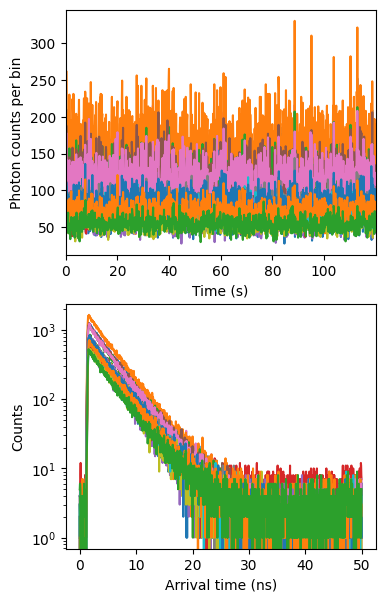

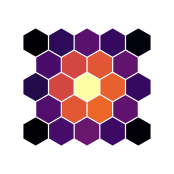

In [11]:
f, axs = plt.subplots(2, 1, figsize=(4,7))

# plot time trace
for i in range(23):
    axs[0].plot(np.linspace(0, duration, 1000), time_trace[:,i+9])
axs[0].set_xlim([0,duration])
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Photon counts per bin')

# plot histograms
for det in range(23):
    hist = getattr(data, "hist" + str(det+9))
    axs[1].plot(1e-3*hist[:,0], hist[:,1])
axs[1].set_xlabel('Arrival time (ns)')
axs[1].set_ylabel('Counts')
axs[1].set_yscale('log')

# plot finger print
_ = plot_fingerprint_luminosa(np.sum(time_trace, 0), cmap='inferno', plot=True, figsize=(2,2))

### Plot correlations

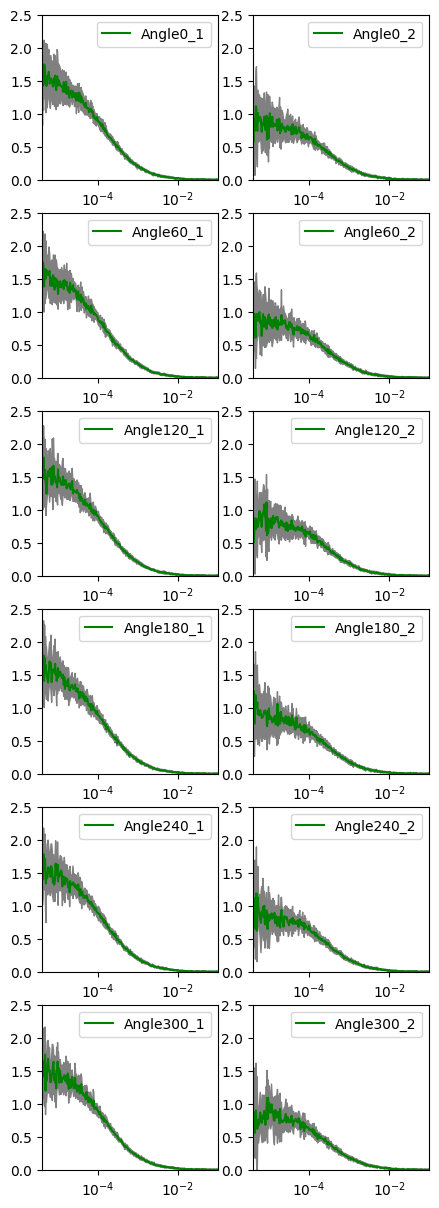

In [12]:
num_chunks = G.num_chunks

f, axs = plt.subplots(6, 2, figsize=(5,15))

for i, corr in enumerate(list_of_g_out):
    row = i//2
    column = np.mod(i, 2)
    Gsingle = getattr(G, corr + '_average')
    tau = Gsingle[1:,0]
    Gy = Gsingle[1:,1]
    Gstd = Gsingle[1:,2]
    axs[row][column].fill_between(tau, Gy-Gstd, Gy+Gstd, color='grey')
    axs[row][column].plot(tau, Gy, label=corr, c='green') # average correlation
    axs[row][column].set_xscale('log')
    #axs[row][column].set_title(corr)
    axs[row][column].legend()
    #axs[row][column].set_xlabel('Lag time (s)')
    #axs[row][column].set_ylabel('G')
    axs[row][column].set_xlim([4e-6, 1e-1])
    axs[row][column].set_ylim([0, 2.5])

### Average over good chunks

In [13]:
idx = good_chunks_idx(G, filt='Angle0_1', f_acc=0.66) # look at all the Angle0_1 curves and accept best 66 percent
G.average_chunks(idx) # average good chunks for all 12 curves

Text(0.5, 1.0, 'Average over 66perc best curves')

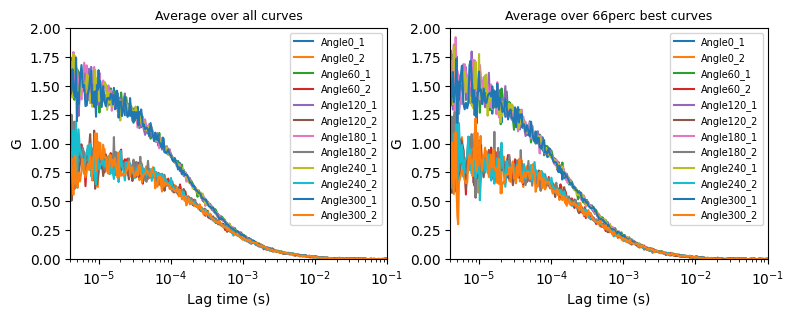

In [18]:
f, axs = plt.subplots(1, 2, figsize=(9,3))

for i, corr in enumerate(list_of_g_out):
    axs[0].plot(Gsingle[1:,0], getattr(G, corr + '_average')[1:,1], label=corr)
    axs[1].plot(Gsingle[1:,0], getattr(G, corr + '_averageX')[1:,1], label=corr)

for i in range(2):
    axs[i].set_xscale('log')
    axs[i].set_xlim([4e-6, 1e-1])
    axs[i].set_ylim([0, 2])
    axs[i].set_xlabel('Lag time (s)')
    axs[i].set_ylabel('G')
    axs[i].legend(fontsize=7)
axs[0].set_title('Average over all curves', fontsize=9)
axs[1].set_title('Average over 66perc best curves', fontsize=9)

### Fit correlations

Fit 1 component dual focus FCS

In [19]:
from brighteyes_ffs.fcs.fcs_fit import fcs_fit_dualfocus as my_fit_fun

In [20]:
# order of parameters:     N      D      w0     SF     rhox   rhoy   vx     vy     offset
# units                           um2/s  nm            nm     nm     um/s   um/s
fit_info     = np.asarray([True,  True,  True,  False, False, False, False, False, False]) # should the parameter be fitted?
global_param = np.asarray([True,  True,  False, False, False, False, True,  True,  False]) # should the parameter be the same for every curve?
lbounds      = np.asarray([1e-12, 1e-12, 1e-12, 1e-12, 1e-12, 1e-12, 1e-12, 1e-12, 1e-12]) # lower bounds in case of fit
ubounds      = np.asarray([1e12,  1e12,  1e12,  1e12,  1e12,  1e12,  1e12,  1e12,  1e12])  # upper bounds in case of fit

rho_all = [72.0, 144.0, 72.0, 144.0, 72.0, 144.0, 72.0, 144.0, 72.0, 144.0, 72.0, 144.0] # nm
start_idx = 350
stop_idx = 700

param = np.zeros((len(fit_info), len(list_of_g_out)))
for i, corr in enumerate(list_of_g_out):
    param[:, i] = np.asarray([1, 50, 200, 5.0, rho_all[i], 0, 0, 0, 0]) # starting values

G_all, tau, weights = G.get_av_corrs(list_of_g_out)

fitresult = fcs_fit(G_all[start_idx:stop_idx,:], tau[start_idx:stop_idx], my_fit_fun, fit_info, param,
                    lbounds, ubounds, plotInfo=-1, global_param=global_param, weights=1+0*weights[start_idx:stop_idx,:])

print('All 9 values for all 12 curves:')
print_table(fitresult.x)

All 9 values for all 12 curves:
    0.55    0.55    0.55    0.55    0.55    0.55    0.55    0.55    0.55    0.55    0.55    0.55
   64.48   64.48   64.48   64.48   64.48   64.48   64.48   64.48   64.48   64.48   64.48   64.48
  181.04  191.23  181.47  189.78  181.36  194.38  179.64  188.84  180.83  191.81  181.76  195.70
    5.00    5.00    5.00    5.00    5.00    5.00    5.00    5.00    5.00    5.00    5.00    5.00
   72.00  144.00   72.00  144.00   72.00  144.00   72.00  144.00   72.00  144.00   72.00  144.00
    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00
    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00
    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00
    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00


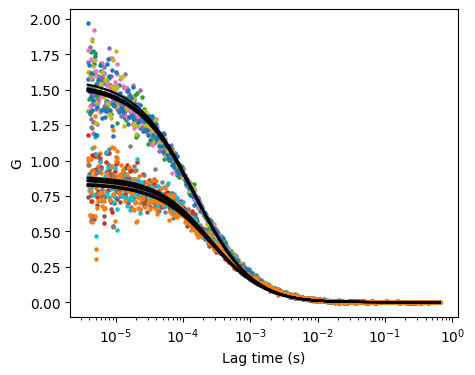

In [21]:
f, axs = plt.subplots(1, figsize=(5,4))

for i, corr in enumerate(list_of_g_out):
    Gsingle = getattr(G, corr + '_averageX')
    axs.scatter(Gsingle[start_idx:stop_idx,0], Gsingle[start_idx:stop_idx,1], s=5, label=corr)
    axs.plot(Gsingle[start_idx:stop_idx,0], Gsingle[start_idx:stop_idx,1]-fitresult.fun[:,i], c='k')
    axs.set_xscale('log')
    axs.set_xlabel('Lag time (s)')
    axs.set_ylabel('G')
    #axs.legend()

In [22]:
print(f"N = {fitresult.x[0,0]:.2f}")
print(f"D = {fitresult.x[1,0]:.2f} um^2/s")

T = 293  # temperature in K
visc = 1e-3  # viscosity in Pa.s
D = fitresult.x[1,0]
diameter = 1e9 * stokes_einstein(1e-12 * D, T, visc)
print(f"--> diameter: {diameter:.2f} nm")

N = 0.55
D = 64.48 um^2/s
--> diameter: 6.66 nm


## Calculate all cross-correlations without symmetry averaging

In [23]:
list_of_g, list_of_g_out, averaging = get_corr_input(corrtype='crossall-ext', det=detector)
[G2, time_trace] = correlate_file(file, list_of_g=list_of_g, accuracy=accuracy, split=split, time_trace=return_time_trace, list_of_g_out=list_of_g_out, averaging=averaging)

tag index out of order @ 'DNA_40bp_Alexa488.ptu' tagid='DetectorTCSPCChan', index=4, typecode=268435464, value=9
tag index out of order @ 'DNA_40bp_Alexa488.ptu' tagid='DetectorNumTCSPCChan', index=4, typecode=268435464, value=23


Calculating correlation x0909
Extracting photons channels 09 and 09
   Filter 0
Calculating correlation x0910
Extracting photons channels 09 and 10
   Filter 0
Calculating correlation x0911
Extracting photons channels 09 and 11
   Filter 0
Calculating correlation x0912
Extracting photons channels 09 and 12
   Filter 0
Calculating correlation x0913
Extracting photons channels 09 and 13
   Filter 0
Calculating correlation x0914
Extracting photons channels 09 and 14
   Filter 0
Calculating correlation x0915
Extracting photons channels 09 and 15
   Filter 0
Calculating correlation x0916
Extracting photons channels 09 and 16
   Filter 0
Calculating correlation x0917
Extracting photons channels 09 and 17
   Filter 0
Calculating correlation x0918
Extracting photons channels 09 and 18
   Filter 0
Calculating correlation x0919
Extracting photons channels 09 and 19
   Filter 0
Calculating correlation x0920
Extracting photons channels 09 and 20
   Filter 0
Calculating correlation x0921
Extracting

In [26]:
Gall, tau, Gstd = G2.get_av_corrs(G2.list_of_g_out, av='_average') # we didn't filter so we use the average of all chunks

Text(0, 0.5, 'G')

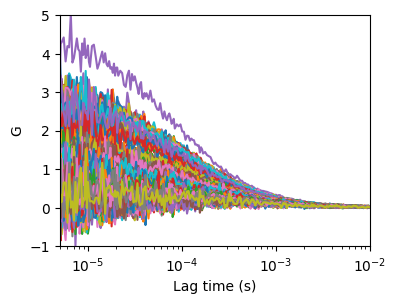

In [32]:
plt.figure(figsize=(4,3))
for i in range(len(G2.list_of_g_out)):
    plt.plot(tau[1:], Gall[1:, i])
plt.xscale('log')
plt.xlim([5e-6, 1e-2])
plt.ylim([-1, 5])
plt.xlabel('Lag time (s)')
plt.ylabel('G')

In [101]:
# order of parameters:     N      D      w0     SF     rhox   rhoy   vx     vy     offset
fit_info     = np.asarray([True,  True,  True,  False, False, False, False, False, False]) # should the parameter be fitted?
global_param = np.asarray([True,  True,  False, False, False, False, True,  True,  False]) # should the parameter be the same for every curve?
lbounds      = np.asarray([1e-12, 1e-12, 1e-12, 1e-12, 1e-12, 1e-12, 1e-12, 1e-12, 1e-12]) # lower bounds in case of fit
ubounds      = np.asarray([1e12,  1e12,  1e12,  1e12,  1e12,  1e12,  1e12,  1e12,  1e12])  # upper bounds in case of fit

# calculate the distance between all pairs of elements in nm
# for the luminosa, elements are numbered from 9 (bottom right) to 31 (upper left)
# 72 nm is the distance between nearest neighbours elements in the sample space
rho_all = [72 * distance_between_elements("pda-23", i+9, j+9) for i in range(23) for j in range(23)]

param = np.zeros((len(fit_info), len(G2.list_of_g_out)))
for i, corr in enumerate(G2.list_of_g_out):
    param[:, i] = np.asarray([1, 50, 200, 5.0, rho_all[i], 0, 0, 0, 0]) # starting values

G_all, tau, G_std = G2.get_av_corrs(G2.list_of_g_out, '_average')

G_std[G_std==0] = np.min(G_std[G_std!=0])
weights = 1/G_std**2
weights /= np.max(weights)
weights = np.clip(weights, 1e-4, None)

fitresult = fcs_fit(G_all[start_idx:stop_idx,:], tau[start_idx:stop_idx], my_fit_fun, fit_info, fitresult.x,
                    lbounds, ubounds, plotInfo=-1, global_param=global_param, weights=weights[start_idx:stop_idx,:])

(0.0, 5.0)

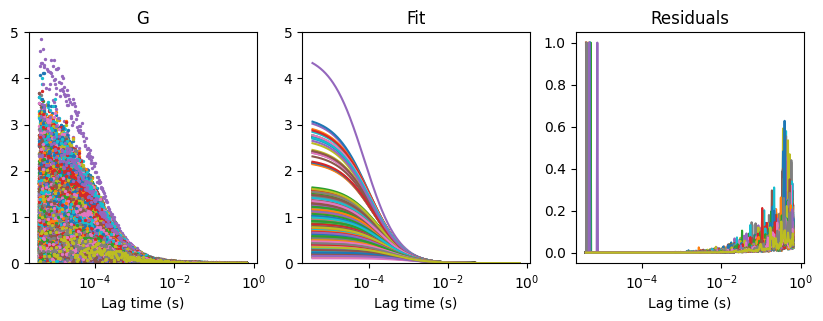

In [95]:
f, axs = plt.subplots(1, 3, figsize=(10,3))
for f, corr in enumerate(G2.list_of_g_out):
    Gsingle = getattr(G2, corr + '_average')
    axs[0].scatter(tau[start_idx:stop_idx], Gsingle[start_idx:stop_idx,1], s=2)
    #axs[2].scatter(tau[start_idx:stop_idx], Gsingle[start_idx:stop_idx,1], s=2)

for f, corr in enumerate(G2.list_of_g_out):
    Gsingle = getattr(G2, corr + '_average')
    axs[1].plot(tau[start_idx:stop_idx], Gsingle[start_idx:stop_idx,1]-fitresult.fun[:,f])
    axs[2].plot(tau[start_idx:stop_idx], weights[start_idx:stop_idx,f])

titles = ['G', 'Fit', 'Residuals']
for i in range(3):
    axs[i].set_xscale('log')
    axs[i].set_xlabel('Lag time (s)')
    axs[i].set_title(titles[i])

axs[0].set_ylim([0, 5])
axs[1].set_ylim([0, 5])

In [96]:
print(f"N = {fitresult.x[0,0]:.2f}")
print(f"D = {fitresult.x[1,0]:.2f} um^2/s")

T = 293  # temperature in K
visc = 1e-3  # viscosity in Pa.s
D = fitresult.x[1,0]
diameter = 1e9 * stokes_einstein(1e-12 * D, T, visc)
print(f"--> diameter: {diameter:.2f} nm")

N = 2.53
D = 89.67 um^2/s
--> diameter: 4.79 nm


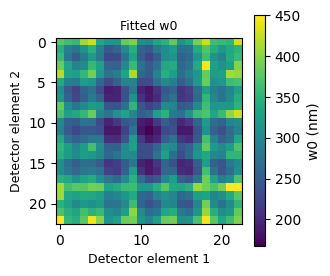

In [97]:
plt.figure(figsize=(3,3))
plt.imshow(np.reshape(fitresult.x[2,:], (23,23)), vmin=None, vmax=450)
plt.xlabel('Detector element 1', fontsize=9)
plt.ylabel('Detector element 2', fontsize=9)
plt.title('Fitted w0', fontsize=9)
plt.colorbar(label='w0 (nm)')